# Setup

In [10]:
pip install pytorch-tabnet

In [11]:
pip install wget

# Customize a TabNet Model

## This tutorial gives examples on how to easily customize a TabNet Model

### 1 - Customizing your learning rate scheduler

Almost all classical pytroch schedulers are now easy to integrate with pytorch-tabnet

### 2 - Use your own loss function

It's really easy to use any pytorch loss function with TabNet, we'll walk you through that


### 3 - Customizing your evaluation metric and evaluations sets

Like XGBoost, you can easily monitor different metrics on different evaluation sets with pytorch-tabnet

## 1 - Customizing your learning rate scheduler

TabNetClassifier, TabNetRegressor and TabNetMultiTaskClassifier all takes two arguments:
- scheduler_fn : Any torch.optim.lr_scheduler should work
- scheduler_params : A dictionnary that contains the parameters of your scheduler (without the optimizer)

----
NB1 : Some schedulers like torch.optim.lr_scheduler.ReduceLROnPlateau depend on the evolution of a metric, pytorch-tabnet will use the early stopping metric you asked (the last eval_metric, see 2-) to perform the schedulers updates

EX1 : 
```
scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params={"mode":'max', # max because default eval metric for binary is AUC
                 "factor":0.1,
                 "patience":1}
```

-----
NB2 : Some schedulers require updates at batch level, they can be used very easily the only thing to do is to add `is_batch_level` to True in your `scheduler_params`

EX2:
```
scheduler_fn=torch.optim.lr_scheduler.CyclicLR
scheduler_params={"is_batch_level":True,
                  "base_lr":1e-3,
                  "max_lr":1e-2,
                  "step_size_up":100
                  }
```

-----
NB3: Note that you can also customize your optimizer function, any torch optimizer should work

## 2 - Use your own loss function

The default loss for classification is torch.nn.functional.cross_entropy

The default loss for regression is torch.nn.functional.mse_loss

Any derivable loss function of the type lambda y_pred, y_true : loss(y_pred, y_true) should work if it uses torch computation (to allow gradients computations).

In particular, any pytorch loss function should work.

Once your loss is defined simply pass it loss_fn argument when defining your model.

/!\ : One important thing to keep in mind is that when computing the loss for TabNetClassifier and TabNetMultiTaskClassifier you'll need to apply first torch.nn.Softmax() to y_pred as the final model prediction is softmaxed automatically.

NB : Tabnet also has an internal loss (the sparsity loss) which is summed to the loss_fn, the importance of the sparsity loss can be mitigated using `lambda_sparse` parameter

In [12]:
def my_loss_fn(y_pred, y_true):
    """
    Dummy example similar to using default torch.nn.functional.cross_entropy
    """
    softmax_pred = torch.nn.Softmax(dim=-1)(y_pred)
    logloss = (1-y_true)*torch.log(softmax_pred[:,0])
    logloss += y_true*torch.log(softmax_pred[:,1])
    return -torch.mean(logloss)

## 3 - Customizing your evaluation metric and evaluations sets

When calling the `fit` method you can speficy:
- eval_set : a list of tuples like (X_valid, y_valid)
    Note that the last value of this list will be used for early stopping
- eval_name : a list to name each eval set
    default will be val_0, val_1 ...
- eval_metric : a list of default metrics or custom metrics
    Default : "auc", "accuracy", "logloss", "balanced_accuracy", "mse", "rmse"
    
    
NB : If no eval_set is given no early stopping will occure (patience is then ignored) and the weights used will be the last epoch's weights

NB2 : If `patience<=0` this will disable early stopping

NB3 : Setting `patience` to `max_epochs` ensures that training won't be early stopped, but best weights from the best epochs will be used (instead of the last weight if early stopping is disabled)

In [13]:
from pytorch_tabnet.metrics import Metric

In [14]:
class my_metric(Metric):
    """
    2xAUC.
    """

    def __init__(self):
        self._name = "custom" # write an understandable name here
        self._maximize = True

    def __call__(self, y_true, y_score):
        """
        Compute AUC of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            AUC of predictions vs targets.
        """
        return 2*roc_auc_score(y_true, y_score[:, 1])

# Prepare data

In [24]:
!pip install gdown

!gdown https://drive.google.com/u/0/uc?id=1A1Db5DagEK2NUYGrq2k5H1TM9biEOSRt
!mkdir data
!unzip data.zip -d data

Downloading...
From: https://drive.google.com/u/0/uc?id=1A1Db5DagEK2NUYGrq2k5H1TM9biEOSRt
To: /content/data.zip
209MB [00:02, 76.8MB/s]


In [31]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

### Download census-income dataset

### Prepared data

In [38]:
import os.path as osp

data_dir = osp.join(os.getcwd(), 'data')
files_list = list(os.walk(data_dir))[0][2]
print(files_list)

['data_dict10_test.csv', 'data_dict10.csv']


In [39]:
exp_name_1 = 'data_dict10.csv'
path_to_csv_1 = osp.join(data_dir, exp_name_1)
print(path_to_csv_1)
data_1 = pd.read_csv(path_to_csv_1, encoding='utf-8', )  # index_col=0
data_1.drop('Unnamed: 0', axis=1, inplace=True)

/content/data/data_dict10.csv


In [40]:
exp_name_2 = 'data_dict10_test.csv'
path_to_csv_2 = osp.join(data_dir, exp_name_2)
print(path_to_csv_2)
data_2 = pd.read_csv(path_to_csv_2, encoding='utf-8')  # index_col=0
data_2.drop('Unnamed: 0', axis=1, inplace=True)

/content/data/data_dict10_test.csv


In [41]:
dataset_name = exp_name_1 + ' + ' + exp_name_2
data = pd.concat([data_1, data_2])

### Load data and split

In [42]:
# labels = [ f'{i}' for i in range(0, 5, 1) ]
# data['mass_idx'] = pd.cut(data['mass'], range(0, 6, 1), right=False, labels=labels)
# data['mass_idx'] = data['mass_idx'].astype(int)

In [43]:
col_to_drop = ['TrPP']

for col_name in col_to_drop:
  data.drop(col_name, axis=1, inplace=True)

In [44]:
data

,TrEP,TrXc,TrYc,TrZe,TrAz,TrNe,TrNg,TrNm,TrNh,mass
0,14.231187,2.243103,-68.253601,21.673889,82.030411,3.660676,4.460266,3.192010,3.013680,0.000000
1,14.721252,-62.188171,-35.751892,38.479443,319.859131,3.627571,4.383438,3.724522,2.550228,1.386294
2,14.079951,-8.422974,-87.365540,13.028395,263.789581,3.930490,4.671636,3.350442,2.903090,1.386294
3,14.661968,-33.348572,48.912720,29.256182,245.556931,4.006894,4.758852,3.676419,3.040602,0.000000
4,14.238879,-89.837463,-39.299622,26.789837,192.263596,3.598024,4.372009,3.380211,3.228657,1.386294
...,...,...,...,...,...,...,...,...,...,...
708930,15.409324,-56.603333,-30.968201,32.021900,93.730156,4.445527,5.206648,4.451541,3.411451,4.025352
708931,14.231819,37.949219,-76.676575,23.864639,94.082687,3.596487,4.386535,3.327154,3.197556,0.000000
708932,14.155507,52.666504,27.992676,32.300289,346.376343,3.443889,4.215426,3.246499,2.970347,0.000000
708933,14.674331,-55.184265,-9.475830,38.424881,128.708206,3.685114,4.445168,3.767304,2.755112,3.332205


In [45]:
target = 'mass'
ignore_col = 'mass_idx'

# data = data.head(100000)
if "Set" not in data.columns:
    data["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(data.shape[0],))

train_indices = data[data.Set=="train"].index
valid_indices = data[data.Set=="valid"].index
test_indices = data[data.Set=="test"].index

In [46]:
print(len(train_indices))
print(len(valid_indices))
print(len(test_indices))

2269073
283416
283250


### Simple preprocessing

Label encode categorical features and fill empty cells.

In [47]:
nunique = data.nunique()
types = data.dtypes

categorical_columns = []
categorical_dims =  {}

# for col in data.columns:
#     if types[col] == 'object' or nunique[col] < 200:
#         print(col, data[col].nunique())
#         l_enc = LabelEncoder()
#         data[col] = data[col].fillna("VV_likely")
#         data[col] = l_enc.fit_transform(data[col].values)
#         categorical_columns.append(col)
#         categorical_dims[col] = len(l_enc.classes_)
#     else:
#         data.fillna(data.loc[train_indices, col].mean(), inplace=True)

### Define categorical features for categorical embeddings

In [48]:
unused_feat = ['Set', ignore_col]

features = [ col for col in data.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Training

In [51]:
X_train = data[features].values[train_indices]
y_train = data[target].values[train_indices]

X_valid = data[features].values[valid_indices]
y_valid = data[target].values[valid_indices]

X_test = data[features].values[test_indices]
y_test = data[target].values[test_indices]

n_targets = 1
y_train = np.transpose(np.tile(y_train, (n_targets,1)))
y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))
y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [52]:
print(f'TRAIN:\t{X_train.shape},\t{y_train.shape}')
print(f'VAILD:\t{X_valid.shape},\t{y_valid.shape}')
print(f'TEST:\t{X_test.shape},\t{y_test.shape}')

TRAIN:	(2269073, 9),	(2269073, 1)
VAILD:	(283416, 9),	(283416, 1)
TEST:	(283250, 9),	(283250, 1)


## sklearn

In [53]:
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor
regressor = DecisionTreeRegressor(splitter='random', max_depth=70)

In [54]:
regressor.fit(np.concatenate((X_train, X_valid), axis=0), np.concatenate((y_train, y_valid), axis=0))
print(regressor.score(X_test, y_test))

0.8804645984600941


In [55]:
sk_preds = regressor.predict(X_test)

In [71]:
error_list = []
total = 0
true_count_sk = 0
error_range = 0.1
for yy_true, yy_pred_sk in zip(y_test, sk_preds):
  yy_true = yy_true[0]
  error_b = abs(yy_pred_sk - yy_true)
  error_list.append([ yy_true, yy_pred_sk, error_b])
  total += 1

  if error_b < error_range:
    true_count_sk += 1
print(f'{true_count_sk/total*100:0.2f}%')
error_list = np.array(error_list)
res_df = pd.DataFrame(error_list, columns=['y_true', 'y_pred_sk', 'error_sk'])

85.74%


In [64]:
res_df.describe()

,y_true,y_pred_sk,error_sk
count,283250.000000,283250.000000,2.832500e+05
mean,2.153875,2.151581,1.715915e-01
std,1.418904,1.419325,4.595818e-01
min,0.000000,0.000000,0.000000e+00
25%,1.386294,1.386294,0.000000e+00
50%,2.484907,2.484907,0.000000e+00
75%,3.332205,3.332205,4.440892e-16
max,4.025352,4.025352,4.025352e+00


In [65]:
import seaborn as sns

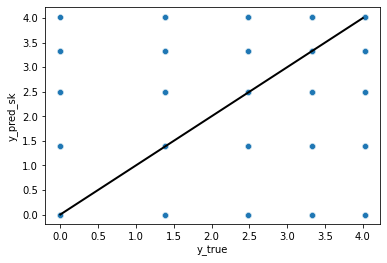

In [66]:
sns.scatterplot(data=res_df, x='y_true', y='y_pred_sk')
plt.plot([0, 4], [0, 4], linewidth=2, color='black')

[-0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15
  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05  1.15  1.25  1.35
  1.45  1.55  1.65  1.75  1.85  1.95  2.05  2.15  2.25  2.35  2.45  2.55
  2.65  2.75  2.85  2.95  3.05  3.15  3.25  3.35  3.45  3.55  3.65  3.75
  3.85  3.95  4.05  4.15  4.25  4.35  4.45  4.55  4.65  4.75  4.85  4.95]


Text(0.5, 0.98, 'Errors')

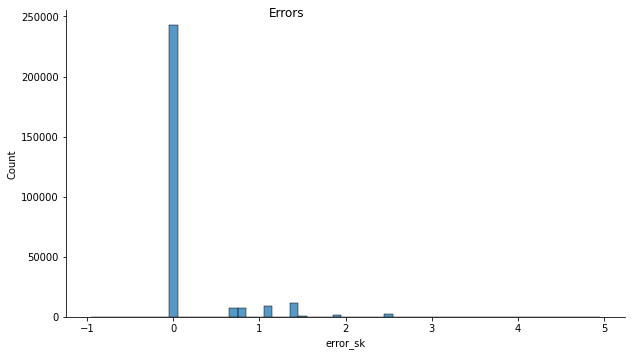

In [73]:
bins_width = 0.1
bins_min, bins_max = -1, 5
bins = np.arange(bins_min+bins_width/2, bins_max+bins_width/2, bins_width)
pl = sns.displot(res_df, x="error_sk", bins=bins)
print(bins)
# Add a title to the Figure
pl.fig.set_size_inches(10, 5)
pl.fig.suptitle("Errors", fontsize=12)

## TabNet

In [ ]:
# Network parameters
max_epochs = 100 if not os.getenv("CI", False) else 2
batch_size = 10240

# net = TabNetClassifier(cat_idxs=cat_idxs,
#                        cat_dims=cat_dims,
#                        cat_emb_dim=1,
#                        optimizer_fn=torch.optim.Adam, # Any optimizer works here
#                        optimizer_params=dict(lr=2e-2),
#                        scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
#                        scheduler_params={"is_batch_level":True,
#                                          "max_lr":5e-2,
#                                          "steps_per_epoch":int(data.shape[0] / batch_size)+1,
#                                          "epochs":max_epochs
#                                           },
#                        mask_type='entmax', # "sparsemax",
#                       )

# net = TabNetRegressor(cat_idxs=cat_idxs,
#                       cat_dims=cat_dims,
#                       cat_emb_dim=1,
#                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
#                       optimizer_params=dict(lr=1e-6),
#                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
#                       scheduler_params={"is_batch_level":True,
#                                         "max_lr":2e-4,
#                                         "steps_per_epoch":int(data.shape[0] / batch_size)+1,
#                                         "epochs":max_epochs
#                                         },
#                       mask_type='entmax', # "sparsemax",
#                       )

net = TabNetRegressor(cat_idxs=cat_idxs,
                      cat_dims=cat_dims,
                      cat_emb_dim=1,
                      optimizer_fn=torch.optim.Adam, # Any optimizer works here
                      optimizer_params=dict(lr=1e-4),
                      scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                      scheduler_params={"patience":10,
                                        "threshold":0.01,
                                        },
                      mask_type='entmax', # "sparsemax",
                      )

Device used : cuda


In [ ]:
net.scheduler_params['threshold'] = 0.01
net.scheduler_params['patience'] = 10
net.scheduler_params['factor'] = 0.1
net.optimizer_params=dict(lr=1e-4)
net.optimizer_fn=torch.optim.Adam
max_epochs = 200 if not os.getenv("CI", False) else 2

In [ ]:
net.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'val'],
    eval_metric=['mse'],  # choose in ['auc', 'accuracy', 'balanced_accuracy', 'logloss', 'mae', 'mse', 'rmse', 'custom', 'custom', 'custom']
    max_epochs=max_epochs,
    patience=0,
    batch_size=batch_size,
    virtual_batch_size=batch_size/8,
    num_workers=0,
    drop_last=False,
    # loss_fn=my_loss_fn
) 


No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.36297 | train_mse: 0.35541 | val_mse: 0.35544 |  0:01:13s
epoch 1  | loss: 0.36183 | train_mse: 0.35434 | val_mse: 0.35438 |  0:02:26s
epoch 2  | loss: 0.36058 | train_mse: 0.35301 | val_mse: 0.35307 |  0:03:40s
epoch 3  | loss: 0.35938 | train_mse: 0.35216 | val_mse: 0.35218 |  0:04:52s
epoch 4  | loss: 0.35836 | train_mse: 0.35107 | val_mse: 0.3511  |  0:06:05s
epoch 5  | loss: 0.35741 | train_mse: 0.35022 | val_mse: 0.35017 |  0:07:19s
epoch 6  | loss: 0.35647 | train_mse: 0.34943 | val_mse: 0.34947 |  0:08:32s
epoch 7  | loss: 0.35574 | train_mse: 0.34879 | val_mse: 0.34882 |  0:09:44s
epoch 8  | loss: 0.35479 | train_mse: 0.34788 | val_mse: 0.34791 |  0:10:55s
epoch 9  | loss: 0.3541  | train_mse: 0.34731 | val_mse: 0.34735 |  0:12:06s
epoch 10 | loss: 0.35326 | train_mse: 0.34654 | val_mse: 0.34657 |  0:13:17s
epoch 11 | loss: 0.35257 | train_mse: 0.34609 | val_mse: 0.34605 |  0:14:29s
epo

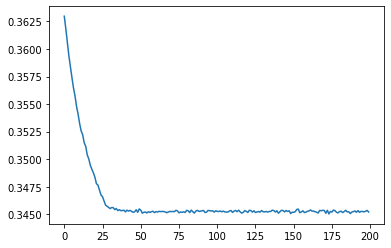

In [ ]:
# plot losses
plt.plot(net.history['loss'])

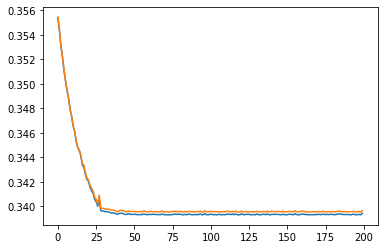

In [ ]:
# plot mse
plt.plot(net.history['train_mse'])
plt.plot(net.history['val_mse'])

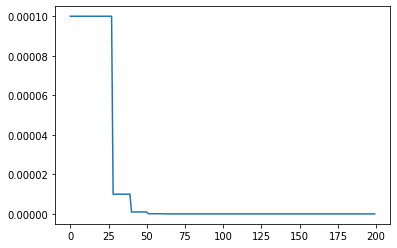

In [ ]:
# plot learning rates
plt.plot(net.history['lr'])

## Predictions

In [ ]:
preds = net.predict(X_test)
test_mse = mean_squared_error(y_test, preds)

preds_valid = net.predict(X_valid)
valid_mse = mean_squared_error(y_valid, preds_valid)


print(f"FINAL VALID SCORE FOR {dataset_name} : {net.history['val_mse'][-1]}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_mse}")

FINAL VALID SCORE FOR data_dict10.csv + data_dict10_test.csv : 0.33963631589306253
FINAL TEST SCORE FOR data_dict10.csv + data_dict10_test.csv : 0.33938321054362697


In [ ]:
error_list = []
total = 0
true_count = 0
true_count_sk = 0
error_range = 0.5
for yy_true, yy_pred, yy_pred_sk in zip(y_test, preds, sk_preds):
  yy_true = yy_true[0]
  yy_pred = yy_pred[0]
  yy_pred_sk = yy_pred_sk[0]
  error_a = yy_pred - yy_true
  error_b = yy_pred_sk - yy_true
  error_list.append([ yy_true, yy_pred, yy_pred_sk, error_a, error_b])
  total += 1
  if abs(error_a) < error_range:
    true_count += 1
  if abs(error_b) < error_range:
    true_count_sk += 1
print(f'{true_count/total*100:0.2f}%')
print(f'{true_count_sk/total*100:0.2f}%')
error_list = np.array(error_list)
res_df = pd.DataFrame(error_list, columns=['y_true', 'y_pred', 'y_pred_sk', 'error', 'error_sk'])

66.16%
85.53%


In [ ]:
res_df

,y_true,y_pred,y_pred_sk,error,error_sk
0,1.386294,1.416229,1.386294,0.029934,0.000000e+00
1,2.484907,2.080724,2.484907,-0.404183,0.000000e+00
2,0.000000,-0.159998,0.000000,-0.159998,0.000000e+00
3,1.386294,1.548118,1.386294,0.161823,0.000000e+00
4,3.332205,3.248074,3.332205,-0.084130,0.000000e+00
...,...,...,...,...,...
283245,0.000000,0.198108,0.000000,0.198108,0.000000e+00
283246,2.484907,1.941336,2.484907,-0.543570,4.440892e-16
283247,1.386294,0.237602,1.386294,-1.148692,0.000000e+00
283248,2.484907,1.534488,2.484907,-0.950419,0.000000e+00


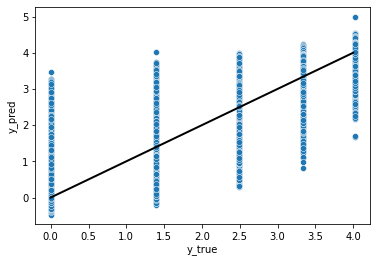

In [ ]:
sns.scatterplot(data=res_df, x='y_true', y='y_pred')
plt.plot([0, 4], [0, 4], linewidth=2, color='black')

In [ ]:
u_mass = data[target].unique()
u_mass.sort()
print(u_mass)
for i in range(len(u_mass)-1):
  print(u_mass[i+1] - u_mass[i])

[0.         1.38629436 2.48490665 3.33220451 4.02535169]
1.3862943611198906
1.0986122886681098
0.8472978603872034
0.6931471805599458


[-4.875 -4.625 -4.375 -4.125 -3.875 -3.625 -3.375 -3.125 -2.875 -2.625
 -2.375 -2.125 -1.875 -1.625 -1.375 -1.125 -0.875 -0.625 -0.375 -0.125
  0.125  0.375  0.625  0.875  1.125  1.375  1.625  1.875  2.125  2.375
  2.625  2.875  3.125  3.375  3.625  3.875  4.125  4.375  4.625  4.875]


Text(0.5, 0.98, 'Errors')

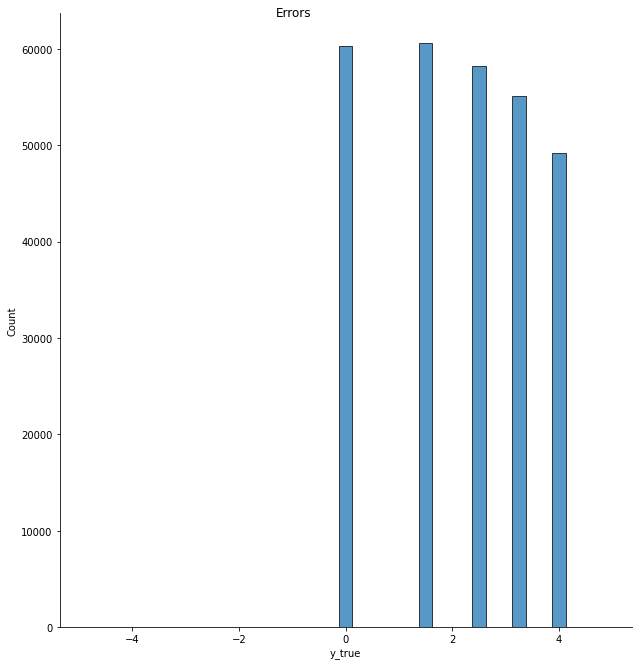

In [ ]:
bins_width = 0.25
bins_min, bins_max = -5, 5
bins = np.arange(bins_min+bins_width/2, bins_max+bins_width/2, bins_width)
pl = sns.displot(res_df, x="y_true", bins=bins)
print(bins)
# Add a title to the Figure
pl.fig.set_size_inches(10, 10)
pl.fig.suptitle("Errors", fontsize=12)

[-3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25  0.25  0.75  1.25  1.75
  2.25  2.75  3.25  3.75]


Text(0.5, 0.98, 'Errors')

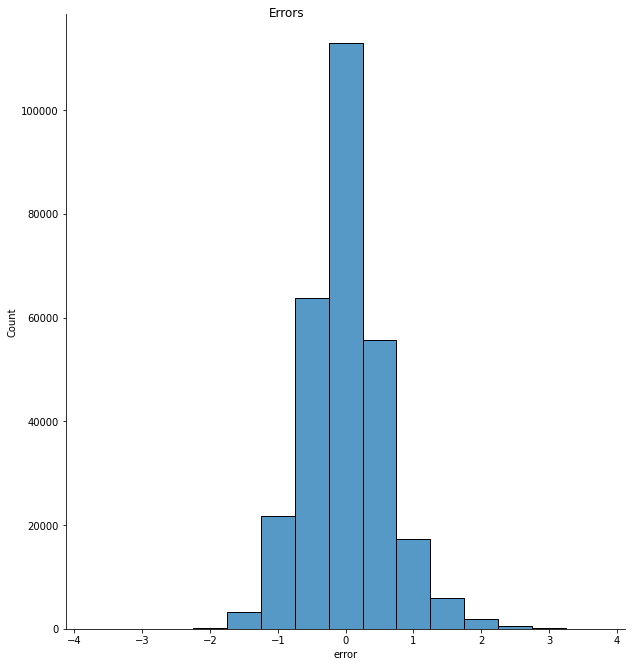

In [ ]:
bins_width = 0.5
bins_min, bins_max = -4, 4
bins = np.arange(bins_min+bins_width/2, bins_max+bins_width/2, bins_width)
pl = sns.displot(res_df, x="error_sk", bins=bins)
print(bins)
# Add a title to the Figure
pl.fig.set_size_inches(10, 10)
pl.fig.suptitle("Errors", fontsize=12)

In [ ]:
# check that last epoch's weight are used
assert np.isclose(valid_mse, net.history['val_mse'][-1], atol=1e-6)

# Save and load Model

In [ ]:
# save tabnet model
saving_path_name = r"/content/drive/My Drive/Colab Notebooks/KCDC/tab_net_100e_100b_all_samples"
saved_filepath = net.save_model(saving_path_name)

Successfully saved model at /content/drive/My Drive/Colab Notebooks/KCDC/tab_net_100e_100b_all_samples.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_net = TabNetRegressor()
loaded_net.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [ ]:
loaded_preds = loaded_net.predict(X_test)
loaded_test_mse = mean_squared_error(y_test[:, 0], loaded_preds[:,1])

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR data_dict10.csv + data_dict10_test.csv : 0.16975177917490752


In [ ]:
assert(test_mse == loaded_test_mse)

AssertionError: ignored

# Global explainability : feat importance summing to 1

In [ ]:
reg.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

# Local explainability and masks

In [ ]:
explain_matrix, masks = reg.explain(X_test)

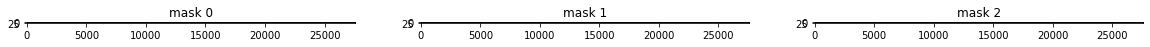

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

In [ ]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)